In [1]:
import numpy as np
import cv2 as cv
import torch
import pandas as pd
import time
from Kalmantool import KalmanFilter
from Analyze import LimitedQueue
from Analyze import CalPeriod



def rotation_pred(recent_x):
    data_aug = 1
    flame_len = len(recent_x)
    y = np.array(range(flame_len))
    k, _ = np.polyfit(recent_x * data_aug, y, deg=1)
    print(k)
    if k < 0: return 1
    else: return 0

bullet_time = 0.1 # example bullet_time=0.1

rotation_dir = 1 # 1: to left; 0: to right

# meta params
QUEUE_LEN = 500

# model = torch.hub.load('ultralytics/yolov5', 'yolov5s') # download from github
# model = torch.hub.load('ultralytics/yolov5', 'custom', 'runs/train/exp14/weights/best.pt')
model = torch.hub.load('ultralytics/yolov5', 'custom', 'runs/train/exp18/weights/best.pt')

# cap = cv.VideoCapture(0)
cap = cv.VideoCapture('E:/innovProject/video/RotationTarget.mp4')

# set Kalman
dt = 1.0/15
F = np.array([[1, dt, 0], [0, 1, dt], [0, 0, 1]])
H = np.array([1, 0, 0]).reshape(1, 3)
Q = np.array([[0.05, 0.05, 0.0], [0.05, 0.05, 0.0], [0.0, 0.0, 0.0]])
R = np.array([0.5]).reshape(1, 1)
kf_x = KalmanFilter(F=F, H=H, Q=Q, R=R)
kf_y = KalmanFilter(F=F, H=H, Q=Q, R=R)

rd = []
locx_base = []
locy_base = []
predictions_x = []
predictions_y = []
# locx_base = LimitedQueue(QUEUE_LEN)
# locy_base = LimitedQueue(QUEUE_LEN)
# predictions_x = LimitedQueue(QUEUE_LEN)
# predictions_y = LimitedQueue(QUEUE_LEN)

period_stat = []

Using cache found in C:\Users\LaoZhu/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2022-11-1 Python-3.8.8 torch-1.11.0+cu113 CUDA:0 (NVIDIA GeForce RTX 2070, 8192MiB)

Fusing layers... 
Model summary: 157 layers, 1760518 parameters, 0 gradients, 4.1 GFLOPs
Adding AutoShape... 


In [2]:
current_fps = 0
if not cap.isOpened():
    print('Cannot open camera')
    exit()
while True:
    time_start = time.time()
    ret, image = cap.read()
    if not ret:
        print('Cannot receive frame')
        break
    
    current_fps += 1
    results = model(image)
    locations = results.pandas().xyxy[0]
    try:
        # get locations named 'mark'
        obj = locations.loc[locations['name'] == 'mark'] # target name

        # get first target locations
        obj_x = obj.iloc[0]['xmin']
        obj_y = obj.iloc[0]['ymin']
        obj_width = obj.iloc[0]['xmax'] - obj_x
        obj_height = obj.iloc[0]['ymax'] - obj_y
        obj_x = float(obj_x)
        obj_y = float(obj_y)

        # kalman update
        kf_x.update(obj_x)
        kf_y.update(obj_y)

        # after Kalman
        next_x = float(np.dot(H, kf_x.predict())[0])
        next_y = float(np.dot(H, kf_y.predict())[0])
        
        # visualize
        cv.rectangle(image, (int(obj_x), int(obj_y)), (int(obj_x+obj_width), int(obj_y+obj_height)), (0,255,0),2) # yolo
        cv.rectangle(image, (int(next_x), int(next_y)), (int(next_x+obj_width), int(next_y+obj_height)), (255,255,255),2) # kalman 
        

        if d_x != None:
            if rotation_dir == 1:
                cv.rectangle(image, (int(next_x-d_x), int(next_y)), (int(next_x+obj_width-d_x), int(next_y+obj_height)), (0,255,255),2)
            elif rotation_dir == 0:
                cv.rectangle(image, (int(next_x+d_x), int(next_y)), (int(next_x+obj_width+d_x), int(next_y+obj_height)), (0,255,255),2)


        # save data
        # - current location
        locx_base.append(obj_x)
        locy_base.append(obj_y)
        predictions_x.append(next_x)
        predictions_y.append(next_y)
        # - serialize
        x_arr = np.array(locx_base)
        y_arr = np.array(locy_base)

        x_pre_arr = np.array(predictions_x)
        y_pre_arr = np.array(predictions_y)



    except:
        # print('No obj detected')
        predictions_x.append(0)
        predictions_y.append(0)
        locx_base.append(0)
        locy_base.append(0)

        x_pre_arr = np.array(predictions_x)
        y_pre_arr = np.array(predictions_y)

    if current_fps > 10:
        current_period = CalPeriod.period(x_pre_arr, process_time)

        d_x = (1000/current_period) * bullet_time

        if len(x_pre_arr) > 200:
            try:
                rotation_dir = rotation_pred(x_pre_arr[-200:])
                rd.append(rotation_dir)
            except:
                pass

        # statistics
        period_stat.append(current_period)

        print('current_period: ', current_period)

    cv.imshow('obj', image)   
    time_end = time.time()
    process_time = time_end - time_start

    try: fps = 1 / process_time 
    except: fps = 0
    print('FPS: ', int(fps), 'serials: ', current_fps)

    if cv.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv.destroyAllWindows()


# 实际上应该是1.81s左右

FPS:  7 serials:  1
FPS:  25 serials:  2
FPS:  38 serials:  3
FPS:  35 serials:  4
FPS:  24 serials:  5
FPS:  28 serials:  6
FPS:  32 serials:  7
FPS:  31 serials:  8
FPS:  45 serials:  9
FPS:  47 serials:  10
current_period:  0.23100686073303223
FPS:  45 serials:  11
current_period:  0.2640266418457031
FPS:  45 serials:  12
current_period:  0.28598856925964355
FPS:  47 serials:  13
current_period:  0.29399538040161133
FPS:  47 serials:  14
current_period:  0.31501293182373047
FPS:  45 serials:  15
current_period:  0.35205841064453125
FPS:  45 serials:  16
current_period:  0.37397289276123047
FPS:  45 serials:  17
current_period:  0.39598846435546875
FPS:  49 serials:  18
current_period:  0.380049467086792
FPS:  47 serials:  19
current_period:  0.4200315475463867
FPS:  46 serials:  20
current_period:  0.45407581329345703
FPS:  47 serials:  21
current_period:  0.4620347023010254
FPS:  47 serials:  22
current_period:  0.48302531242370605
FPS:  47 serials:  23
current_period:  0.504032135

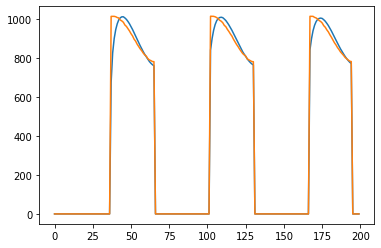

In [3]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

x1 = 0
x2 = 200
# plt.figure(figsize=(10,5))
plt.plot(x_pre_arr[x1:x2])
plt.plot(x_arr[x1:x2])
plt.show()

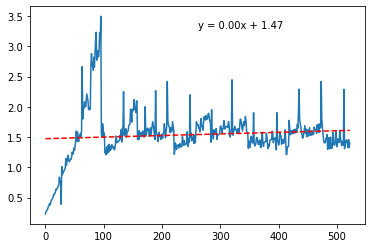

In [4]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt


# 将period_stat转换为NumPy数组，并将x轴坐标设为该数组的索引值
period_stat = np.array(period_stat)
x = np.arange(len(period_stat)).reshape(-1, 1)

# 创建并训练线性回归模型
model = LinearRegression()
model.fit(x, period_stat)

# 根据训练好的模型，预测x轴坐标的最小值和最大值对应的y轴坐标值
y_pred = model.predict([[x.min()], [x.max()]])

# 绘制期间统计数据的折线图和回归直线，并在图上标注回归结果
plt.plot(period_stat)
plt.plot([x.min(), x.max()], y_pred, color='r', linestyle='--')
plt.text(0.5, 0.9, 'y = {:.2f}x + {:.2f}'.format(model.coef_[0], model.intercept_), transform=plt.gca().transAxes)

plt.show()

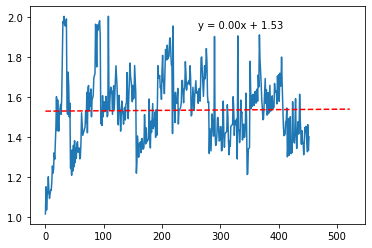

In [5]:
import numpy as np
from scipy import stats
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# period_stat = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# 将period_stat转换为NumPy数组，并将x轴坐标设为该数组的索引值
period_stat = np.array(period_stat)
x = np.arange(len(period_stat)).reshape(-1, 1)

# 使用IQR方法识别离群点，去除离群点后的数据集为filtered_entries
Q1, Q3 = np.percentile(period_stat, [25, 75])
IQR = stats.iqr(period_stat)
lower_bound = Q1 - (1.5 * IQR)
upper_bound = Q3 + (1.5 * IQR)
filtered_entries = np.logical_and(period_stat > lower_bound, period_stat < upper_bound)

# 创建并训练线性回归模型
model = LinearRegression()
model.fit(x[filtered_entries], period_stat[filtered_entries])

# 根据训练好的模型，预测x轴坐标的最小值和最大值对应的y轴坐标值
y_pred = model.predict([[x.min()], [x.max()]])

# 绘制期间统计数据的折线图和回归直线，并在图上标注回归结果
plt.plot(period_stat[filtered_entries])
plt.plot([x.min(), x.max()], y_pred, color='r', linestyle='--')
plt.text(0.5, 0.9, 'y = {:.2f}x + {:.2f}'.format(model.coef_[0], model.intercept_), transform=plt.gca().transAxes)

plt.show()


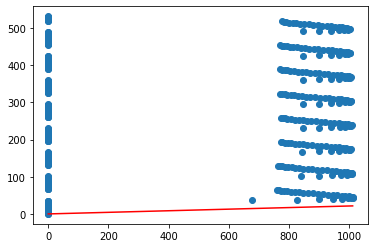

In [12]:
flame_len = len(x_pre_arr)
y = np.array(range(flame_len))
k, _ = np.polyfit(x_pre_arr, y, deg=1)

plt.scatter(x_pre_arr, y)

# 绘制拟合的直线
x = np.linspace(np.min(x_pre_arr), np.max(x_pre_arr), 100)
y_fit = k * x
plt.plot(x, y_fit, 'r')

# 显示图形
plt.show()

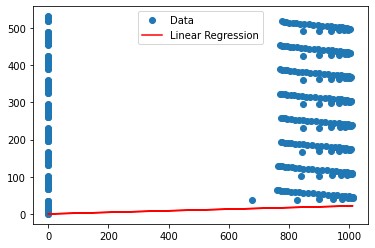

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# 假设 x_pre_arr 和 data_aug 已经定义好了
flame_len = len(x_pre_arr)
y = np.array(range(flame_len))
k, _ = np.polyfit(x_pre_arr, y, deg=1)

# 计算回归线上的点坐标
y_fit = k * x_pre_arr

# 绘制原始数据点和回归线
plt.plot(x_pre_arr, y, 'o', label='Data')
plt.plot(x_pre_arr, y_fit, '-r', label='Linear Regression')
plt.legend()
plt.show()
